In [3]:
from pystac import Catalog
from pystac import StacIO

from pystac_client import Client
from odc.stac import stac_load, configure_rio
import geopandas as gpd
import folium, shapely

In [4]:
def get_auth():
    # token generation
    from oauthlib.oauth2 import BackendApplicationClient
    from requests_oauthlib import OAuth2Session

    # Your client credentials
    client_id = "adea6192-2672-4296-94aa-1bcb9e5d2df7"
    client_secret = "~BRX82#Ii(-0N<,iVI@.d<lw~<sd~Ti?GU.N!6Y)"

    # Create a session
    client = BackendApplicationClient(client_id=client_id)
    oauth = OAuth2Session(client=client)

    # Get token for the session
    gen_token = oauth.fetch_token(
        token_url="https://services.sentinel-hub.com/oauth/token",
        client_secret=client_secret,
    )
    return gen_token["access_token"]


token = get_auth()

headers = {"Content-Type": "application/json", "Authorization": f"Bearer {token}"}
url = "https://services.sentinel-hub.com/api/v1/catalog/1.0.0"

In [5]:
# Create a PySTAC client and open the catalog
client = Client.open(url, headers=headers)

In [7]:
# Retrieve the root catalog
root_catalog = client.get_stac_objects(rel=None)
root_catalog

<generator object STACObject.get_stac_objects at 0x7f283dcf6820>

In [8]:
# Retrieve all catalogs
catalogs = list(client.get_child_links())
catalogs

[<Link rel=child target=https://services.sentinel-hub.com/api/v1/catalog/1.0.0/collections/sentinel-2-l1c>,
 <Link rel=child target=https://services.sentinel-hub.com/api/v1/catalog/1.0.0/collections/sentinel-1-grd>,
 <Link rel=child target=https://services.sentinel-hub.com/api/v1/catalog/1.0.0/collections/sentinel-2-l2a>]

In [9]:
collections = list(client.get_collections())

print(f"Number of collections: {len(collections)}")
print("Collections IDs:")
for collection in collections:
    print(f"- {collection.id}")

Number of collections: 3
Collections IDs:
- sentinel-2-l1c
- sentinel-1-grd
- sentinel-2-l2a


In [12]:
collection = client.get_child("sentinel-2-l2a")
if collection is None:
    print("Collection is Empty. Check your downloads and try agian.")
else:
    print("Collection has a root child. You may proceed.")

Collection has a root child. You may proceed.


In [14]:
bbox = [84.5, 26.5, 86.501, 26.501]

# Set a start and end date
time = "2020-12-10", "2021-02-01"

# Set the STAC collections
collections = ["sentinel-2-l1c"]

In [15]:
query = client.search(bbox=bbox, collections=collections, datetime=time)

# Search the STAC catalog for all items matching the query
items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

Found: 55 datasets


In [16]:
stac_json = query.get_all_items_as_dict()

In [21]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")
gdf.head()

,geometry,datetime,platform,instruments,constellation,gsd,eo:cloud_cover,proj:epsg,proj:bbox,proj:geometry
0,"MULTIPOLYGON (((85.08217 27.04617, 84.85432 26...",2021-02-01T05:01:27Z,sentinel-2b,[msi],sentinel-2,10,99.93,32645,"[199980.0, 2890200.0, 309780.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."
1,"MULTIPOLYGON (((85.09788 27.10958, 84.99021 26...",2021-02-01T05:01:22Z,sentinel-2b,[msi],sentinel-2,10,61.04,32645,"[300000.0, 2890200.0, 409800.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."
2,"MULTIPOLYGON (((85.99066 27.11883, 85.99933 26...",2021-02-01T05:01:18Z,sentinel-2b,[msi],sentinel-2,10,8.11,32645,"[399960.0, 2890200.0, 509760.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."
3,"MULTIPOLYGON (((83.97450 27.08987, 84.00044 26...",2021-01-30T05:11:22Z,sentinel-2a,[msi],sentinel-2,10,100.00,32645,"[199980.0, 2890200.0, 309780.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."
4,"MULTIPOLYGON (((84.98250 27.10797, 84.99982 26...",2021-01-30T05:11:18Z,sentinel-2a,[msi],sentinel-2,10,100.00,32645,"[300000.0, 2890200.0, 409800.0, 3000000.0]","{'type': 'MultiPolygon', 'crs': {'type': 'name..."


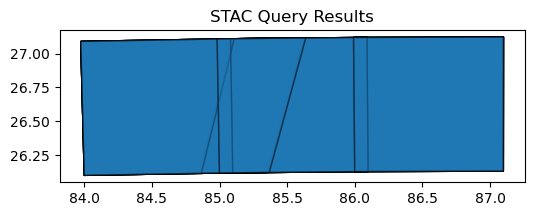

In [22]:
fig = gdf.plot(
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)
_ = fig.set_title("STAC Query Results")

In [23]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure
from odc.stac import configure_rio, stac_load


def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))


fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    categorical=False,
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)